In [1]:
import pandas as pd
from casting.configuration import paths, columns, ranges
from casting.preprocessing import (calculate_defect_rate, 
                                   drop_null, 
                                   remove_extreme_outliers, 
                                   split_by_dbscan,
                                   remove_outlier)
from casting.utils import load_data

from casting.model.train_ML_model import train_xgboost, train_lightgbm, train_extra_trees
from casting.model.train_DL_model import train_tabnet

from casting.model.pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

/var/folders/kc/2d8dbwd13vv1nn8nl99cb98r0000gn/T/ipykernel_72794/2839186551.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')


# preprocessing

### base

In [3]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)

### outlier remove

In [4]:
data = remove_outlier(data)

### data split

In [5]:
split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [6]:
X_train, y_train, X_valid, y_valid = load_data('ml')

test = pd.read_csv(paths.ml_test_path)
X_test, y_test = test[columns.input_columns], test[columns.target_column]

### ML Modeling

In [ ]:
# model = train_extra_trees(X_train, X_valid, y_train, y_valid)
# model = train_lightgbm(X_train, X_valid, y_train, y_valid)
# model = train_xgboost(X_train, X_valid, y_train, y_valid)
# model = train_tabnet(X_train, X_valid, y_train, y_valid)

/Users/yuyeongchan/opt/anaconda3/envs/saas-control-job/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.17877 | val_0_auc: 0.45089 |  0:00:06s
epoch 1  | loss: 0.0837  | val_0_auc: 0.78588 |  0:00:12s
epoch 2  | loss: 0.0675  | val_0_auc: 0.80766 |  0:00:19s
epoch 3  | loss: 0.06241 | val_0_auc: 0.89053 |  0:00:25s
epoch 4  | loss: 0.06579 | val_0_auc: 0.87697 |  0:00:32s
epoch 5  | loss: 0.05878 | val_0_auc: 0.9254  |  0:00:38s
epoch 6  | loss: 0.05481 | val_0_auc: 0.95484 |  0:00:44s
epoch 7  | loss: 0.05035 | val_0_auc: 0.95671 |  0:00:51s
epoch 8  | loss: 0.05123 | val_0_auc: 0.95551 |  0:00:57s
epoch 9  | loss: 0.04933 | val_0_auc: 0.95877 |  0:01:03s
epoch 10 | loss: 0.04871 | val_0_auc: 0.95836 |  0:01:10s
epoch 11 | loss: 0.04606 | val_0_auc: 0.96234 |  0:01:17s
epoch 12 | loss: 0.04495 | val_0_auc: 0.96087 |  0:01:24s
epoch 13 | loss: 0.04676 | val_0_auc: 0.96133 |  0:01:30s
epoch 14 | loss: 0.04879 | val_0_auc: 0.96288 |  0:01:37s
epoch 15 | loss: 0.04245 | val_0_auc: 0.96386 |  0:01:43s
epoch 16 | loss: 0.04103 | val_0_auc: 0.9638  |  0:01:50s
epoch 17 | los

/Users/yuyeongchan/opt/anaconda3/envs/saas-control-job/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


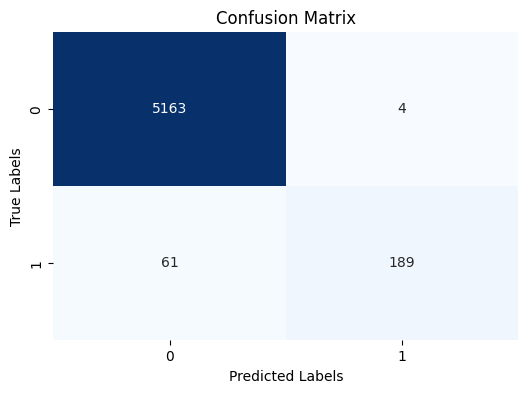

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산

y_pred = model.predict(X_test.values)
test_cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')

F1 Score: 0.8533
accuracy_score: 0.9880
precision_score: 0.9793
recall_score: 0.7560


## FTT Modeling